## 8-1 자율주행 보조장치 KITTI dataset

라이브러리 불러오기

In [70]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/drive/MyDrive/object_detection/data'

print('슝=3')

슝=3


In [71]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


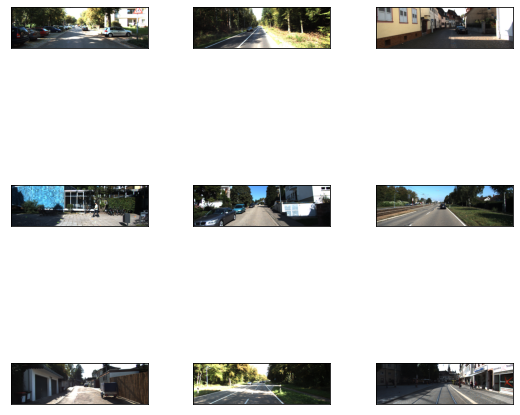

In [72]:
# 다운로드한 KITTI dataset 보기
_ = tfds.show_examples(ds_train, ds_info)

In [73]:
# dataset 정보 확인하기
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

## 8-2 데이터셋 직접 확인하기



------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-1.59, -0.83, -2.65,  2.86,  2.39,  0.51,  2.12,  1.85, -2.89],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.46205333, 0.48361513, 0.53389335, 0.50570047],
       [0.00266667, 0.        , 0.50005335, 0.27213365],
       [0.17842667, 0.63347024, 0.6319733 , 0.7642834 ],
       [0.2436    , 0.63400966, 0.57384   , 0.66219   ],
       [0.28829333, 0.59455717, 0.54477334, 0.62005633],
       [0.19584   , 0.13470209, 0.53136   , 0.16664252],
       [0.27701333, 0.06727859, 0.46786666, 0.20493558],
       [0.43184   , 0.328124  , 0.5038933 , 0.36657006],
       [0.2788    , 0.61063606, 0.6062933 , 0.7017472 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.61, 1.51, 4.5 ],
       [1.72, 0.47, 1.65],
       [1.6 , 0.39, 0.4 ],
       [1.5 ,

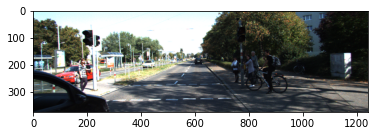

In [74]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

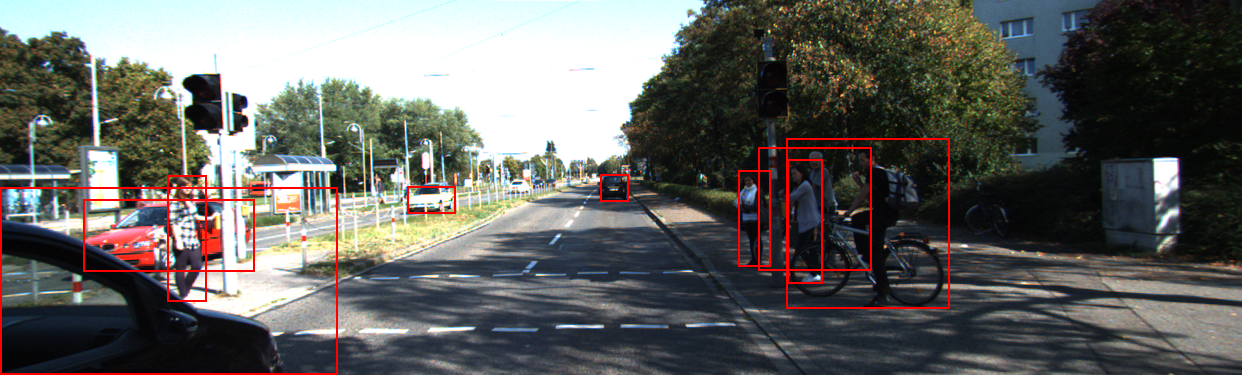

In [75]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 8-3 RetinaNet

- RetinaNet은 `Focal Loss for Dense Object Detection` 논문에서 공개된 detection 모델이다. 

- 1-stage detector 모델이 2-stage detector 모델보다 빠르지만 성능이 낮다는 문제점이 있었고 이를 해결하기 위해 RetinaNet에서는 `focal loss와 FPN(Feature Pyramid Network)`를 적용한 네트워크를 사용하게 되었다.


### Focal Loss
- Focal loss는 기존의 1-stage detection 모델들이 모든 그리드에 대해서 한번에 학습됨으로 생기는 클래스 간의 불균형을 해결하기 위해서 도입되었다. 


- Focal loss는 교차 엔트로피를 기반으로 만들어졌다. 이 교차 엔트로피 때문에 물체 검출 모델을 학습시키는 과정에서 문제가 발생할 수 있는데 이유는 이미지 내에 물체보다 배경이 더 많기 때문이다. 따라서 극단적으로 배경에 class가 많아지는 class imbalanced data라고 할 수 있다.


- 이렇게 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해준다고 한다. 감마를 0으로 설정하면 modulating factor가 1이 되어서 일반적인 교차 엔트로피가 되고 감마가 커질수록 modulating이 강하게 적용된다고 한다.


### FPN(Feature Pyramid Network)

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식이다. 


- 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇개의 숫자로 요약하기 때문에 입력 이미지를 기준으로 보면 먼 모델의 뒷쪽의 특성 맵이면 셀(cell)이 넓은 이미지 영역의 정보를 가지고 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 이미지 영역의 정보를 가지게 된다. 이를 `receptive field`라고 한다.


- 레이어가 깊어질 수록 pooling을 거쳐서 넓은 범위의 정보(receptive field)를 갖게 되는 것이다.


- 위에서 봤듯이 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)해서 앞단의 특성 맵과 더해 사용한다는 것이다. 쉽게말해서 넓게 보는 것과 좁게 보는것을 같이 쓰겠다는 목적인 것이다.

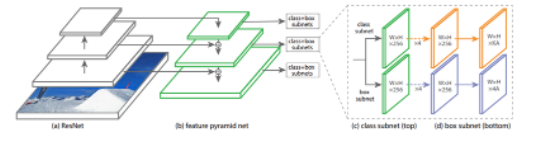


RetinaNet에서 FPN 구조가 어떻게 적용되었는지 보자.


1. RetinaNet에서는 FPN을 통해서 P(3)부터 P(7)까지 pyramid level을 생성해 사용한다.

2. 각 pyramid level은 256개의 채널로 이루어져있다.

3. 이를 통해서 `Classification Subnet`과 `Box Regression Subnet`의 Subnet을 구성하게 되는데 Anchor 갯수를 A라고 한다면 Classification Subnet은 K개 class에 대해서 K*A개 채널, Box Regression Subnet은 4*A개 채널을 사용하게 된다.

## 8-4 데이터 준비

### 데이터 파이프라인
데이터 파이프라인은 4단계로 이루어져있다.

1. x와 y 좌표 위치 교체

2. 무작위로 수평 뒤집기(filp)

3. 이미지 크기 조정 및 패딩 추가

4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]로 수정

In [76]:
# 1번(x,y) 좌표 교체 함수
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [77]:
# 2번(수평 뒤집기) 함수
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


In [78]:
# 3번(이미지 크기 조정, 패딩추가) 함수
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [79]:
# 4번(좌표계 수정)
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [80]:
# 준비된 함수 연결
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 인코딩

One stage detector에서는 Anchor Box라는 위치, 크기, 비율 중 하나로 물체의 위치가 결정된다.

예를 들어 100개의 Anchor Box가 생성되었다면 물체에 가장 근접한 하나가 선택된다. 이렇게 선택된 Anchor Box를 기초로 정확한 위치를 찾게 된다.

또, RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요하게 된다. 그 이유는 FPN의 각 층마다 Anchor Box가 필요하기 때문이다. 

중요한 점으로 RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어있다.

In [81]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야한다. 

여기서 IoU를 사용하게 되는데 IoU가 높은지 낮은지에 따라서 Anchor Box가 정답인지 오답인지 체크해주는 것이다.

In [82]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


실제 라벨을 Anchor Box에 맞춰주기 위해 함수를 작성한다.

`compute_iou` 함수를 이용해 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해준다. 

또 그 Anchor Box와 실제 Anchor Box의 차이를 계산하게 된다.

In [83]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


## 8-5 모델 작성

### Feature Pyramid

FPN을 사용하기 위해 모델을 작성해본다.

In [84]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- Object Detection의 라벨은 class와 box로 이루어지기 때문에 각각 추론하는 부분이 필요한데 그것을 `head`라고 부른다. 

- Backbone에 해당하는 네트워크와 FPN을 통해서 pyramid layer가 추출되면 그 feature를 바탕으로 class를 예상하고 box도 예상한다.

- 하지만 class와 box가 정답인지 아닌지 모르기 때문에 class를 예측하는 head와 box를 예측하는 head가 별도로 필요하게 된다.

이를 구현하기 위해 `build_head`라는 함수를 만들어준다.

In [85]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


In [86]:
# FPN에 이용할 수 있도록 중간 레이어에도 output으로 연결해준다.
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


In [87]:
# Backbone + FPN + classification용 head + box용 head
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


Loss에 대한 구현을 해줘야한다.

- RetinaNet에서는 Focal Loss를 사용하는데 Box Regression은 사용하지 않고 Classification Loss를 계산하는데만 사용한다. 

- Box Regression에는 `Smooth L1 Loss`를 사용하는데 이는 `delta`를 기준으로 계산이 달라지고 Focal Loss를 사용하는 Classification에서는 `alpha`와 `gamma`를 사용해서 물체일 때와 배경일 때 식이 달라지게 된다.

In [88]:

class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


## 8-6 모델 학습

In [89]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

슝=3


Optimizer는 SGD를 사용하고 Learning Rate를 적절히 바꿔야한다.

In [90]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [91]:
# 데이터 전처리를 위한 파이프라인 생성
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


In [92]:
# 학습 시키는 예시코드

# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# callbacks_list = [
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
#         monitor="loss",
#         save_best_only=False,
#         save_weights_only=True,
#         verbose=1,
#     )
# ]

# epochs = 1

# model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     callbacks=callbacks_list
# )

## 8-7 결과 확인하기

In [93]:
model_dir = '/content/drive/MyDrive/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

슝=3


NMS(Non-Max Suppression)은 직접 구현하지 않아도 `tf.image.combined_non_max_suppression`을 사용해서 구현이 가능하다.

출력에 `nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`이 어떤건지 알면 좋다.

In [94]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [95]:
# 추론 가능한 모델 조립
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


In [96]:
# 모델 추론 결과를 시각화하는 함수
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 1, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y2], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y2,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


In [97]:
# 추론시 입력 데이터를 전처리하기 위한 함수
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


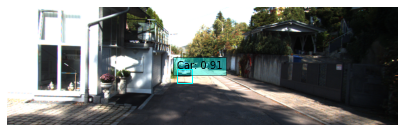

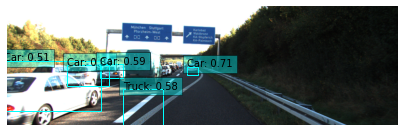

In [98]:
# 학습된 결과를 확인한다.
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

## 8-8 프로젝트 : 자율주행 보조시스템 만들기

In [99]:
import tensorflow as tf

print(tf.__version__)

2.8.0


### 1. 자율주행 시스템 만들기

아래 조건을 만족하는 함수를 구현해본다.

1. 입력으로 이미지 경로를 받는다.
2. 정지조건에 맞는 경우 "Stop" 아니면 'Go'를 반환한다.
3. 다음 조건을 보자.
 - 사람이 한명 이상 있는 경우
 - 차량의 크기가 300px 이상인 경우

In [100]:
def object_detection_result(image):
    int2str = ds_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]

    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    scores = detections.nmsed_scores[0][:num_detections]

    return image, boxes, class_names, scores

In [113]:
def self_drive_assist(model, image_path,
                    size_limit=300, to_visualize=True,
                    people_list = ['Pedestrian', 'Person_sitting', 'Cyclist']
):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image, boxes, class_names, scores = object_detection_result(image)

    if to_visualize:
        visualize_detections(image, boxes, class_names, scores)

    if len(set(class_names) & set(people_list)) > 0:
        return "Stop"

    for box, class_name, score in zip(boxes, class_names, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        if w >= size_limit or h >= size_limit:
            return "Stop"
            
    return "Go"

### 2. 자율주행 시스템 평가하기

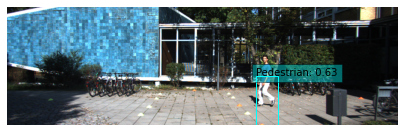

stop_1.png
answer: Stop, prediction: Stop 



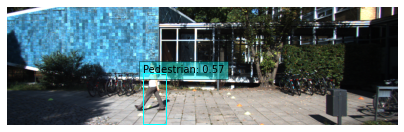

stop_2.png
answer: Stop, prediction: Stop 



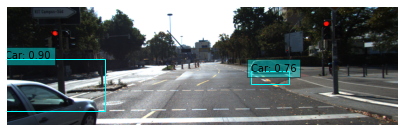

stop_3.png
answer: Stop, prediction: Stop 



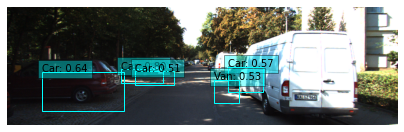

stop_4.png
answer: Stop, prediction: Go 



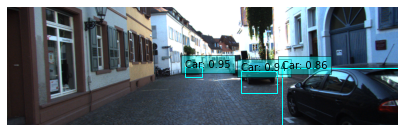

stop_5.png
answer: Stop, prediction: Stop 



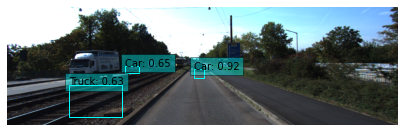

go_1.png
answer: Go, prediction: Go 



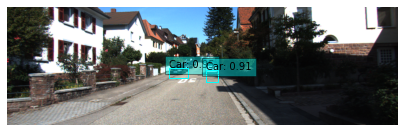

go_2.png
answer: Go, prediction: Go 



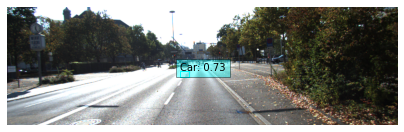

go_3.png
answer: Go, prediction: Go 



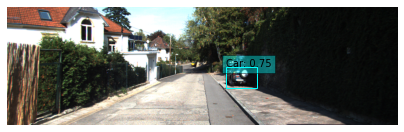

go_4.png
answer: Go, prediction: Go 



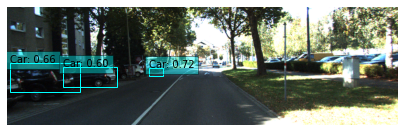

go_5.png
answer: Go, prediction: Go 

90점입니다.


In [115]:
def test_system(func):
    work_dir = '/content/drive/MyDrive/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, image_path=image_path)
        print(image_file)
        print(f'answer: {answer}, prediction: {pred} \n')
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### 회고

가장 기초적인 부분이었겠지만 자율주행에 대해 다룰 수 있어서 좋았다.

하지만 전처리나 코드 구현 부분에 대해서는 난이도가 꽤나 높아서 이해하는데 어려움이 있었다. 

그래도 어떤 방식으로 흘러가게되고 어떻게 구동되는지 나름 이해할 수 있어서 힘들었지만 뜻깊은 주제였다고 생각한다.

당장은 시간이 부족해서 완전히 이해하지는 못했지만 나중에 시간 여유가 되면 좀 자세하게 보는 시간을 가져야겠다.